# Linear Regression Analysis

In this lab we are going to learn how to do simple data analyses using python. 
This module includes learning how to check data, drawing plots for visualization, 
running simple linear regression models, comparing models, visualizing fits,
and making model matrices. 

After the tutorial you will have the chance to apply the methods to a new set of data. 



## Basic Data Checks

Preliminary data checks are important because real life data are rarely clean. 
There are missing values, outliers, miscoded values, and other errors.
In this section we will learn how to detect these errors and prepare our dataset for analysis


In [1]:
# Load some basic modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the data|
df = pd.read_csv('../Data/salary.csv')

In [3]:
whos

Variable   Type         Data/Info
---------------------------------
df         DataFrame        salary  gender  depar<...>\n\n[77 rows x 5 columns]
np         module       <module 'numpy' from '/Us<...>ages/numpy/__init__.pyc'>
pd         module       <module 'pandas' from '/U<...>ges/pandas/__init__.pyc'>
plt        module       <module 'matplotlib.pyplo<...>s/matplotlib/pyplot.pyc'>


In [4]:
# Look at a snippet of data
df.head()

,salary,gender,departm,years,age
0,86285,0,bio,26.0,64.0
1,77125,0,bio,28.0,58.0
2,71922,0,bio,10.0,38.0
3,70499,0,bio,16.0,46.0
4,66624,0,bio,11.0,41.0


In [5]:
# Check how many missing values are in the dataset
np.sum(df.isnull())

salary     0
gender     0
departm    0
years      1
age        1
dtype: int64

In [6]:
# Subset the data by dropping null values
df = df.dropna()

In [7]:
# Check again for missing values
np.sum(df.isnull())

salary     0
gender     0
departm    0
years      0
age        0
dtype: int64

In [8]:
# summarize data; note it doesn't show categorical values...
df.describe(include='all')

,salary,gender,departm,years,age
count,75.000000,75.000000,75,75.000000,75.000000
unique,NaN,NaN,7,NaN,NaN
top,NaN,NaN,bio,NaN,NaN
freq,NaN,NaN,16,NaN,NaN
mean,67293.946667,0.146667,NaN,14.840000,45.426667
std,14672.455177,0.392268,NaN,8.596102,9.051166
min,44687.000000,0.000000,NaN,1.000000,31.000000
25%,56638.500000,0.000000,NaN,8.000000,38.000000
50%,62557.000000,0.000000,NaN,14.000000,44.000000
75%,74733.500000,0.000000,NaN,22.500000,53.000000


In [9]:
# Check what kind of values are in departm
df.departm.describe()

count      75
unique      7
top       bio
freq       16
Name: departm, dtype: object

In [10]:
# Look at the keys 
df.keys()

Index([u'salary', u'gender', u'departm', u'years', u'age'], dtype='object')

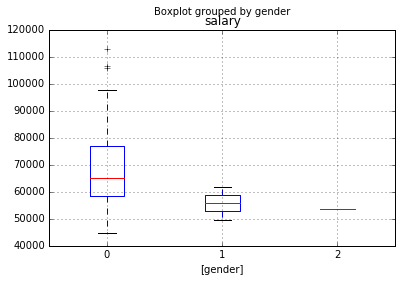

In [11]:
# boxplot data, subset by gender
dfsubset = df[['salary','gender']]
ax=dfsubset.boxplot(by='gender')

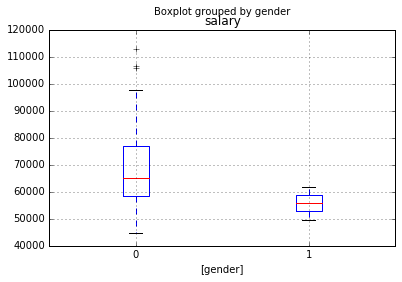

In [12]:
df = df[df['gender']!=2]
# boxplot data, subset by gender
dfsubset = df[['salary','gender']]
ax=dfsubset.boxplot(by='gender')

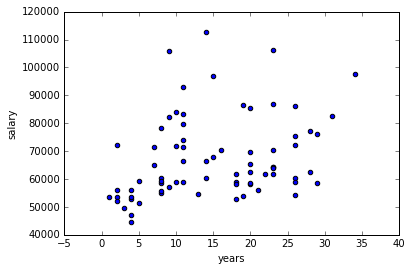

In [13]:
# boxplot data, subset by years
dfsubset = df[['salary','years']]
dfsubset.plot(kind='scatter', x='years', y='salary');

In [ ]:
# Oneshot visualization
## create a new numericalSeries called dept !! Just for visualization !! 
df['dept_num'] = df.departm.map({'bio':0, 'chem':1,'geol':2,'neuro':3,'stat':4,'physics':5,'math':6})
df

In [ ]:
## Now plot all four categories
fig, axs = plt.subplots(1, 4, sharey=True)
df.plot(kind='scatter', x='gender', y='salary', ax=axs[0], figsize=(16, 8))
df.plot(kind='scatter', x='dept_num', y='salary', ax=axs[1])
df.plot(kind='scatter', x='years', y='salary', ax=axs[2])
df.plot(kind='scatter', x='age', y='salary', ax=axs[3])
# The problem is that it treats department as a continuous variable. 

## Linear Regression 

In [ ]:
# Now to the linear model, with Statsmodels
import statsmodels.formula.api as smf
# Create a function for the 
lm = smf.ols(formula = "salary ~ gender",data=df).fit()
print(lm.summary())
# The t stats here indicate whether the coefficient is significantly different from 0

In [ ]:
# Plot Least Squares Line
# create a DataFrame with the minimum and maximum values of X(gender)
X_new = pd.DataFrame({'gender': [df.gender.min(), df.gender.max()]})
X_new.head()
# make predictions for those x values and store them
preds = lm.predict(X_new)
preds
# first, plot the observed data
df.plot(kind='scatter', x='gender', y='salary')
# then, plot the least squares line
plt.plot(X_new, preds, c='red', linewidth=2)

In [ ]:
lm2 = smf.ols(formula = "salary ~ gender + years",data=df).fit()
print(lm2.summary())

In [ ]:
lm3 = smf.ols(formula = "salary ~ gender + years + departm",data=df).fit()
print(lm3.summary())

In [ ]:
ax = plt.figure(figsize=(12,10))
sm.graphics.plot_regress_exog(lm3, 'years',fig=ax)

In [ ]:
# Get regression table, F statistics as if doing Anova
# df for departm is 6 because there was 7 departm categories. 
# F stat tests whether at least one of the coefficients of the variables of a category
# is significantly different from 0 or not
# Type of SSQ to consider https://mcfromnz.wordpress.com/2011/03/02/anova-type-iiiiii-ss-explained/

# Type 1 SSQ
import statsmodels.api as sm
from statsmodels.formula.api import ols
print('ANOVA table for Type 1 SSQ')
print(sm.stats.anova_lm(lm3,typ=1))

# Type 2 SSQ: tests each main effect after the other main effect, without interaction term
print('ANOVA table for Type 2 SSQ')
print(sm.stats.anova_lm(lm3,typ=2))

# Type 3 SSQ: valid for models with significant interaction terms
print('ANOVA table for Type 3 SSQ')
print(sm.stats.anova_lm(lm3,typ=3))

In [ ]:
# Simple model comparison
print(sm.stats.anova_lm(lm,lm2,lm3))

## Design matrices

In [ ]:
# Import requried module
from patsy import dmatrices
# Use the dmatrices function
y, X = dmatrices('salary ~ gender + years + departm', data=df, return_type='dataframe')

In [ ]:
y.head()

In [ ]:
X.head()

# Individual exercise
### Use the 'salary_exercise.csv' to apply the analyses we learned today.